In [1]:
import time
import numpy as np 
import healpy as hp

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


setting the output map dtype to [dtype('float64')]


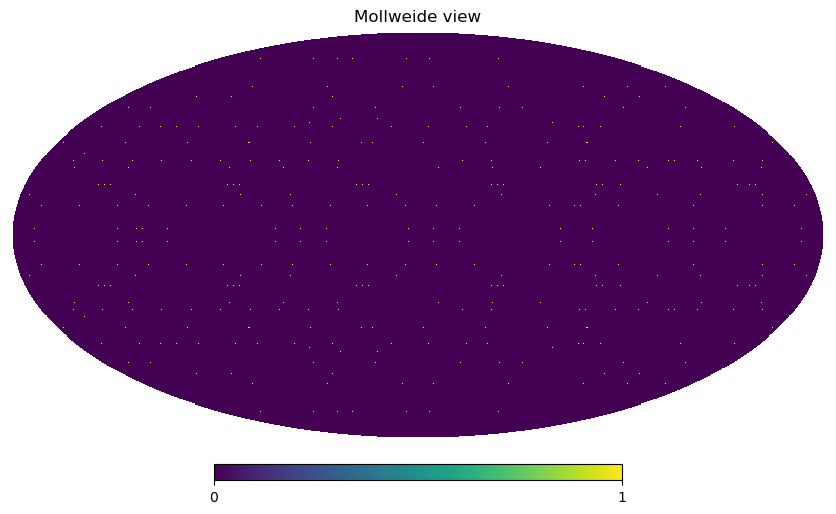

In [8]:
nside1 = 1024
nside2 = 32
map1 = np.zeros(12 * nside1 * nside1)

# Fill the map1 array
for i in range(12 * 32 * 32):
    vec1 = hp.pix2vec(32, i,nest=True)
    pix = hp.vec2pix(1024, vec1[0], vec1[1], vec1[2],nest=True)
    map1[pix] = 1

# Write the map1 array to a FITS file
hp.write_map("map1.fits", map1, overwrite=True,nest=True)
hp.mollview(map1,nest=True)

In [2]:
def RVector(t):
    theta1 = 7.5*np.pi / 180
    theta2 = 85*np.pi / 180
    w1 = 2*np.pi / 60 #rad/sec
    w2 = 2*w1 #rad/sec
    w3 = 3.14159 / 60 #rad/sec
    
    A=[[np.cos(w1*t),np.sin(w1*t),0],
       [-np.sin(w1*t),np.cos(w1*t),0],
       [0,0,1]]
    
    B=[[1,0,0],
       [0,np.cos(w2*t),np.sin(w2*t)],
       [0,-np.sin(w2*t),np.cos(w2*t)]]
    
    C=[[np.cos(theta1),0,np.sin(theta1)],
       [0,1,0],
       [-np.sin(theta1),0,np.cos(theta1)]]
    
    D=[[np.cos(theta2)],
       [np.sin(theta2)*np.cos(w3*t)],
       [np.sin(theta2)*np.sin(w3*t)]]
    
    result1 = np.matmul(A,B)
    result2 = np.matmul(result1,C)
    result = np.matmul(result2,D)
    return result


def SVector(t):
    theta1 = 7.5*np.pi / 180
    theta2 = 0
    w1 = 2*np.pi / 60 #rad/sec
    # w1 = 0.000011954 / 60 #rad/sec
    w2 = 2*w1  #rad/sec
    w3 = 3.14159 / 60 #rad/sec
    
    A=[[np.cos(w1*t),np.sin(w1*t),0],
       [-np.sin(w1*t),np.cos(w1*t),0],
       [0,0,1]]
    
    B=[[1,0,0],
       [0,np.cos(w2*t),np.sin(w2*t)],
       [0,-np.sin(w2*t),np.cos(w2*t)]]
    
    C=[[np.cos(theta1),0,np.sin(theta1)],
       [0,1,0],
       [-np.sin(theta1),0,np.cos(theta1)]]
    
    D=[[np.cos(theta2)],
       [-np.sin(theta2)*np.cos(w3*t)],
       [-np.sin(theta2)*np.sin(w3*t)]]
    
    result1 = np.dot(A,B)
    result2 = np.dot(C,D)
    result = np.dot(result1,result2)
    return result

In [3]:
# angular saperation between two pixel
def ang_distance(theta1,theta2,phi1,phi2):
    # cos(∆θ) = sin(θ1)sin(θ2)cos(φ1 - φ2) + cos(θ1)cos(θ2)
    theta = np.arccos(np.cos(theta1) * np.cos(theta2) + np.sin(theta1) * np.sin(theta2) * np.cos(phi1 - phi2))
    return theta

In [4]:
#  Angle between two vector
def angle_vec(A, B):
    dot_product = np.dot(A, B.T)  # Transpose B to make it a column vector
    mag_A = np.linalg.norm(A)
    mag_B = np.linalg.norm(B)
    
    cos_theta = dot_product / (mag_A * mag_B)
    angle = np.arccos(cos_theta)
    
    return angle

In [5]:
theta1 = 7.5*np.pi / 180
theta2 = 85*np.pi / 180
w1 = 2*np.pi / 60 #rad/sec
w2 = 2*w1 #rad/sec
w3 = 3.14159 / 60 #rad/sec

nside=1024
npix = 12*nside**2

# time_step=scan_time
scan_time = np.sqrt(4*np.pi/npix)/w1
fwhm_x = np.radians(20) 
fwhm_y = np.radians(12)
sigma_x = fwhm_x / np.sqrt(8 * np.log(2)) 
sigma_y = fwhm_y / np.sqrt(8 * np.log(2))

In [9]:
temperature_map = hp.read_map("map1.fits")

In [10]:
def process_time_step(time_step):
    
    t = time_step  

    # 1. Calculate R(t) and S(t) vectors
    R = RVector(t)
    S = SVector(t)

    # 2. Calculate pixel number along R(t) vector (ring format)
    theta_R, phi_R = hp.vec2ang(R)
    pic_ring = hp.ang2pix(nside, theta=theta_R, phi=phi_R)
    nest_pix = hp.ring2nest(nside, pic_ring)

    #3. Calculate Z, I and N (N = I for phi = 0)
    Z_t = np.cross(np.transpose(R), np.transpose(S))
    I_t = np.cross(np.transpose(R), Z_t)
    N_t = I_t
    
    # 4. Find neighboring pixels in NEST format
    # neighbours = hp.get_all_neighbours(nside, nest_pix,nest=True)
    neighbours = hp.query_disc(nside, R , radius=np.radians(0.75),nest = True)

    x = np.zeros_like(neighbours)
    y = np.zeros_like(neighbours)
    
    for i, neighbour_pix in enumerate(neighbours):
        # 5. angular separation between central pixel and neighbouring pixels
        theta_neighbour, phi_neighbour = hp.pix2ang(nside, neighbour_pix,nest=True)
        theta_i = ang_distance(theta_R, theta_neighbour, phi_R, phi_neighbour) 

        # 6. A_i = line joining central pixel and neighbour pixel
        R_i = hp.pix2vec(nside,neighbour_pix,nest=True)
        A_i = np.transpose(R) - R_i

        # 7. angle between N & A_i
        alpha_i = angle_vec(A_i, N_t)

        # 8. x_i and y_i
        x[i] = theta_i * np.cos(alpha_i)
        y[i] = theta_i * np.sin(alpha_i)

    # 9. Retrieve temperatures of neighboring pixels
    neighbor_temperatures = temperature_map[neighbours]


    # 10. Apply elliptical convolution
    convolved_temperature = np.sum(neighbor_temperatures * np.exp(-x**2 / (2 * sigma_x**2) -y**2 / (2 * sigma_y**2))) / np.sum(np.exp(-x**2 / (2 * sigma_x**2) -y**2 / (2 * sigma_y**2)))

    return int(nest_pix),convolved_temperature


- - - - - Vizualization - - - - - 

setting the output map dtype to [dtype('float64')]


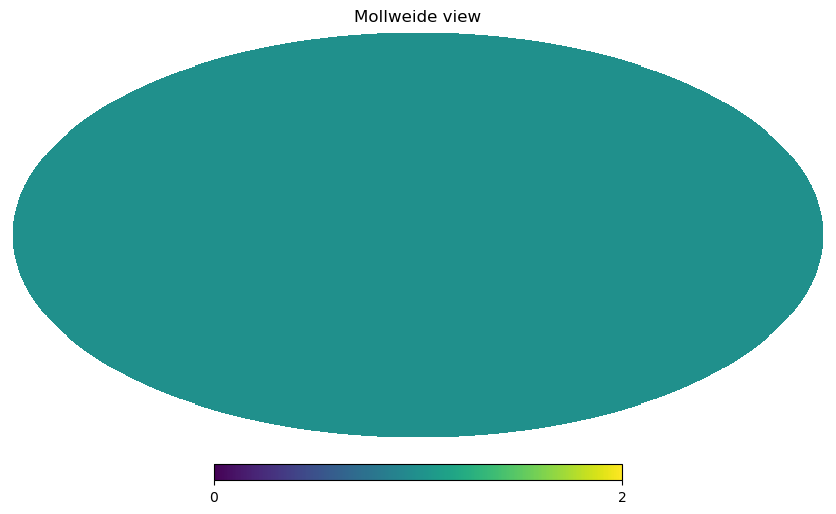

In [11]:
nside = 128
npix = 12*nside*nside
map_array = np.ones(npix)
hp.write_map("ones.fits", map_array, overwrite=True,)
hp.mollview(map_array)

In [12]:
temperature= hp.read_map("ones.fits", nest=True)
sigma_x = 10 / np.sqrt(8 * np.log(2)) 
sigma_y = 5 / np.sqrt(8 * np.log(2)) 
t = 0
R = RVector(t)
S = SVector(t)
# to get the vector N
Z_t = np.cross(np.transpose(R), np.transpose(S))
I_t = np.cross(np.transpose(R), Z_t)
N_t = I_t

#To calculate angular separation 
theta_R, phi_R = hp.vec2ang(R)
pix = hp.vec2pix(nside,R[0],R[1],R[2],nest= True)
#  Get all the neighbours
neighbours = hp.query_disc(nside, R , radius=np.radians(25),nest = True)
for i, neighbour_pix in enumerate(neighbours):
    # print(neighbours[i])
    R_i = hp.pix2vec(nside,neighbour_pix,nest=True)
    A_i = np.transpose(R)-R_i
    # print(A_i)
    # print(N_t,"\n")
    theta_R_i, phi_R_i = hp.pix2ang(nside, neighbour_pix,nest=True)
    alpha_i = angle_vec(A_i, N_t)

    theta_i = ang_distance(theta_R, theta_R_i, phi_R, phi_R_i)

    # set temperature
    x_i = theta_i*np.cos(alpha_i)
    y_i = theta_i*np.sin(alpha_i)
    temperature[neighbour_pix] = np.exp(- (x_i**2/(2*sigma_x**2)) - (y_i**2/(2*sigma_y**2)))

/tmp/ipykernel_19576/4077522880.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  neighbours = hp.query_disc(nside, R , radius=np.radians(25),nest = True)
/tmp/ipykernel_19576/4077522880.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  temperature[neighbour_pix] = np.exp(- (x_i**2/(2*sigma_x**2)) - (y_i**2/(2*sigma_y**2)))


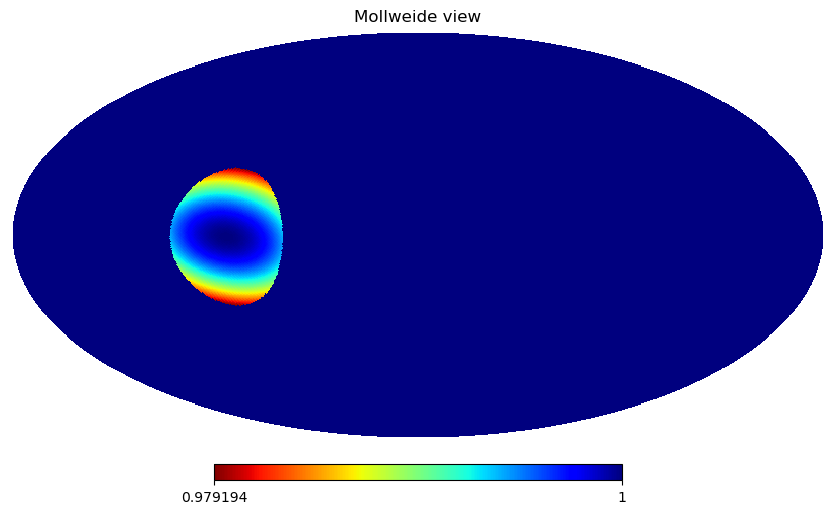

In [13]:
# print(temperature)
hp.mollview(temperature,cmap='jet_r',nest=True)

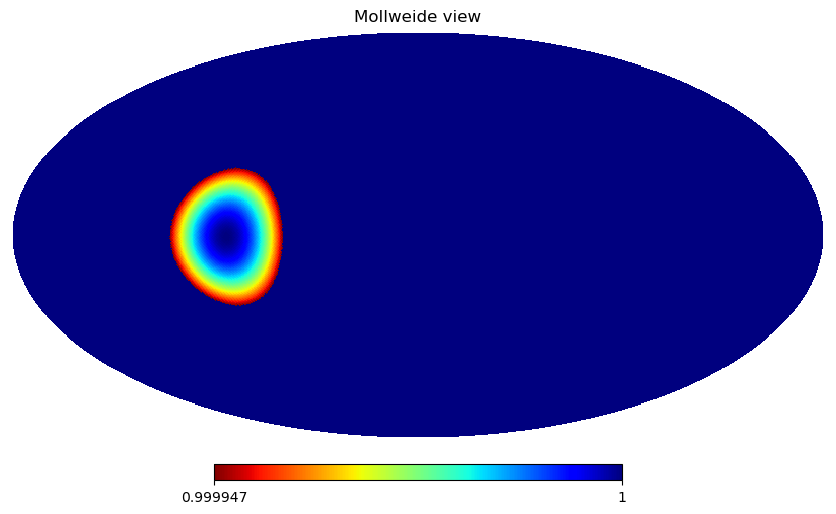

In [16]:
# if sigma_x = sigma_y
hp.mollview(temperature,cmap='jet_r',nest=True)